In [30]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve, 
    roc_auc_score
)

In [2]:
#Load dataset and display basic information
df = pd.read_csv("songs.csv", encoding="ISO-8859-1")

df.info() # Displays columns and types
df.head() # Displays first few columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


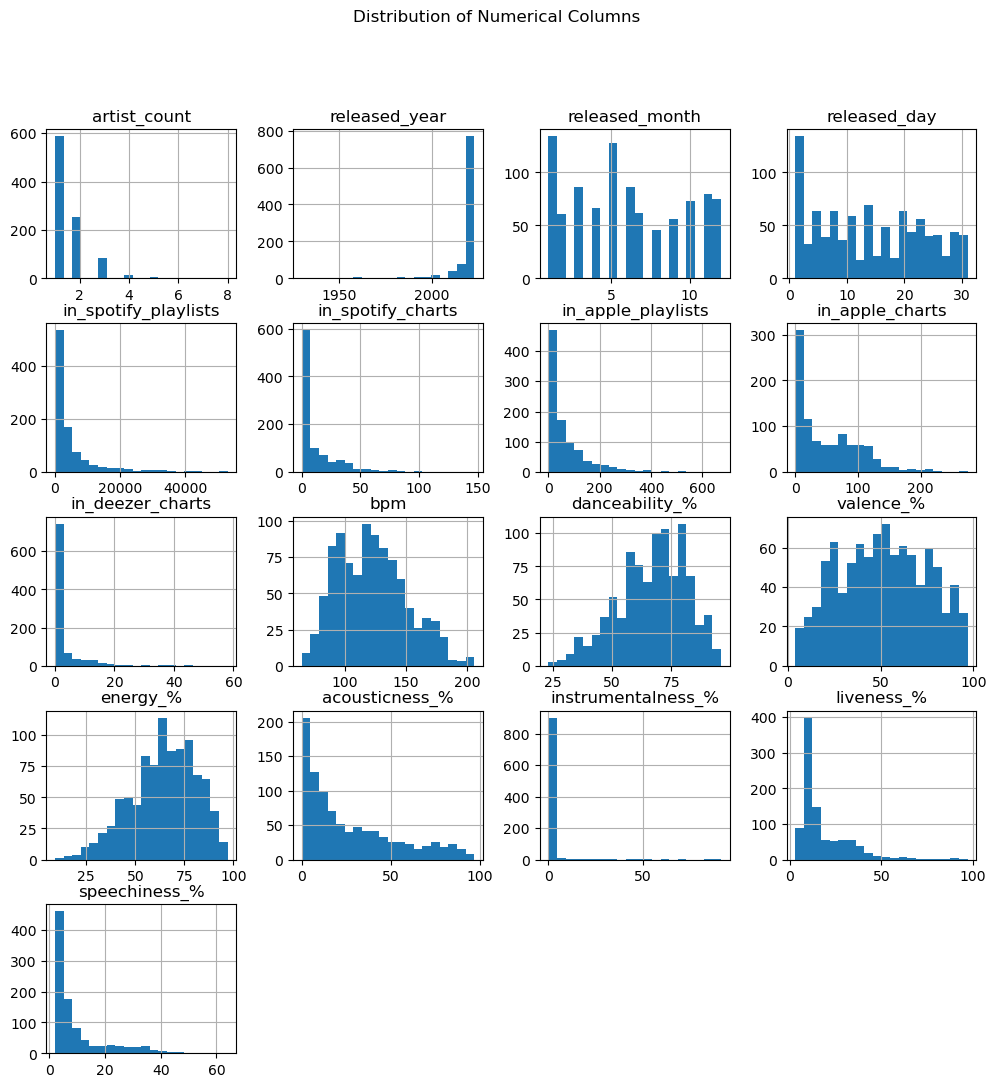

In [3]:
#Plot Data Distribution
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
df[numerical_cols].hist(figsize = (12,12), bins = 20)
plt.suptitle("Distribution of Numerical Columns")
plt.show()

In [4]:
#Drop Columns irrelavent to recommendation algorithm
drop_cols = {'track_name','artist(s)_name'}
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

#Dropping empty columns
df = df.dropna()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns detected:")
print(cat_cols)

#Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(df[cat_cols])
# Convert encoded array back into a DataFrame with readable column names
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Drop original categorical columns from df and concatenate the encoded version
df_encoded = pd.concat([df.drop(columns=cat_cols).reset_index(drop=True),
                        encoded_df.reset_index(drop=True)], axis=1)
df_encoded.head()



Categorical columns detected:
['streams', 'in_deezer_playlists', 'in_shazam_charts', 'key', 'mode']


,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Major,mode_Minor
0,2,2023,7,14,553,147,43,263,10,125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,2023,3,23,1474,48,48,126,14,92,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2023,6,30,1397,113,94,207,14,138,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,2019,8,23,7858,100,116,207,12,170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,2023,5,18,3133,50,84,133,15,144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


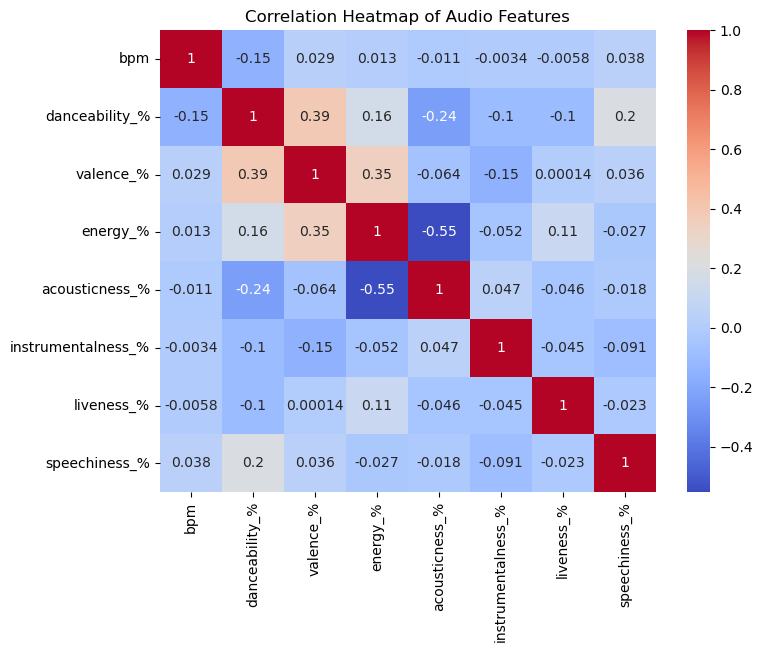

In [5]:
#Assess correlation of numerical features
numeric_features = ['bpm', 'danceability_%', 'valence_%', 'energy_%',
                    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

corr = df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Audio Features")
plt.show()

In [19]:
#Separate target variables into percentage categories
TARGET = 'energy_%'
bins = [0,25,50,75,100]
target_classes = pd.cut(df[TARGET],bins,labels=["25%","50%","75%","100%"])


In [38]:
#Define X and y variables
X = df_encoded.drop(columns=[TARGET])
y = target_classes
y2 = df[TARGET]

#Split X and y into train and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X,y,train_size=.70,random_state=42)

#Take temp set and split into validation and test sets (overall: 70% train, 20% validation, 10% test
X_val,X_test,y_val,y_test = train_test_split(
    X_temp,y_temp,train_size =(2/3),random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

#Initialize Logistic Regression model using pipelinining
model = LogisticRegression(multi_class='auto',random_state=42)
pipeline = Pipeline(
    steps=[
        ("scaler",StandardScaler()),
        ("model",model)
    ]
)
#Fit model
start = time.perf_counter()
pipeline.fit(X_train,y_train)
end = time.perf_counter()
print(f'Training Time: {(end-start):,.2f} seconds')


(571, 1322)
(164, 1322)
(82, 1322)
Training Time: 0.05 seconds


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [42]:
#Calculate model performance
results = []
y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
pre_score = precision_score(y_test, y_pred,average="weighted",zero_division=0)
rec_score = recall_score(y_test,y_pred,average="weighted", zero_division=0)
f1 = f1_score(y_test,y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

#
results.append({
    "Accuracy": acc_score,
    "Precision": pre_score,
    "Recall": rec_score,
    "F1-score": f1
})

#Display results
results_df = pd.DataFrame(results)
display(results_df)

Confusion Matrix:
[[ 9  0  0 12]
 [ 1  0  0  0]
 [ 5  0  0  8]
 [19  0  0 28]]

Classification Report:
              precision    recall  f1-score   support

        100%       0.26      0.43      0.33        21
         25%       0.00      0.00      0.00         1
         50%       0.00      0.00      0.00        13
         75%       0.58      0.60      0.59        47

    accuracy                           0.45        82
   macro avg       0.21      0.26      0.23        82
weighted avg       0.40      0.45      0.42        82



/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Accuracy,Precision (weighted),Recall (weighted),F1-score (weighted)
0,0.45122,0.40214,0.45122,0.421683


(82, 4)
(82, 4)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


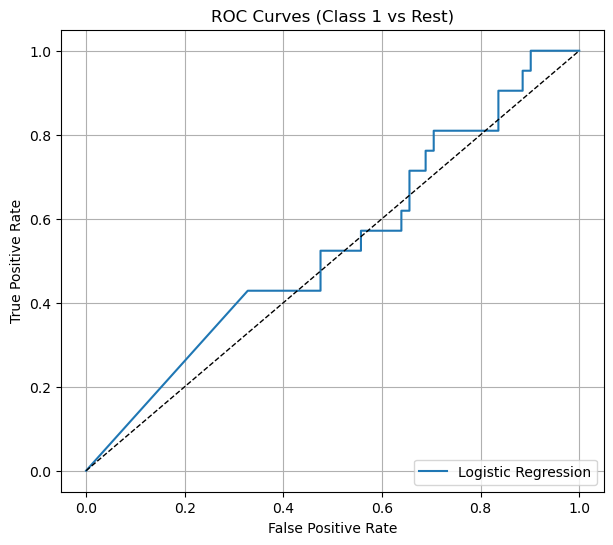

{'Model': 'Logistic Regression', 'AUC (macro OvR)': np.float64(0.44788673680245944)}


In [25]:
#Sort the values of the test set
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test,classes=classes)
roc_data = {}
auc_results = []
y_prob = model.predict_proba(X_test)
print(y_prob.shape)
print(y_test_bin.shape)
class_index = 1 if 1 in classes else 0
fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_prob[:, class_index])
roc_data["Logistic Regression"] = (fpr, tpr)
auc_macro = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
auc_results = {"Model": "Logistic Regression", "AUC (macro OvR)": auc_macro}

#Plot the ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Class 1 vs Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#Display AUC results
print(auc_results)
